In this notebook, I will perform the following tasks:
1.) Encode Data 
2.) Standardize Data
3.) Feature Selection and Feature Engineering
4.) Fit Models
5.) Evaluate Models

In [1154]:

# Set the environment to limit MKL threads
import os
from idlelib.pyparse import trans

os.environ['OMP_NUM_THREADS']= '5'

In [1155]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, OrdinalEncoder, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.feature_selection import VarianceThreshold

In [1156]:
# Load Data

data = pd.read_csv('tech_df_cleaned.csv', index_col=None)
data.describe(include='all')

,number_of_employees,tech_company,mental_health_benefits,mental_health_coverage_awareness,mental_health_offical_communication,mental_health_resources,mental_health_anonymity,asking_for_leave_for_mental_health,discussing_mental_health_with_employer,discussing_physical_health_with_employer,...,at_any_point_diagnosed_MH_disorder,treatment_MH_disorder,interference_with_work_with_effective_treatment,interference_with_work_NOT_effective_treatment,gender,country_residence,country_work,work_position,remote_work,age_group
count,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,...,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146
unique,6,2,4,4,3,3,3,6,3,3,...,2,2,5,5,3,7,7,180,3,6
top,26-100,Yes,Yes,No,No,No,I don't know,Somewhat easy,Maybe,No,...,No,Yes,Not applicable to me,Often,Male,North America,North America,Back-end Developer,Sometimes,30-39
freq,292,883,531,354,813,531,742,281,487,837,...,579,657,455,422,846,774,779,238,611,543


In [1157]:
# Create a data frame to show all features and their unique values. This will help me determine which features to encode using OneHotEncoder, MultiLabelBinarizer, or OrdinalEncoder.

unique_categories = {}

for column in data.columns:
    unique_categories[column] = data[column].unique()
    
# Convert dictionary to data frame
unique_categories_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in unique_categories.items() ]))

# Display data frame
unique_categories_df



,number_of_employees,tech_company,mental_health_benefits,mental_health_coverage_awareness,mental_health_offical_communication,mental_health_resources,mental_health_anonymity,asking_for_leave_for_mental_health,discussing_mental_health_with_employer,discussing_physical_health_with_employer,...,at_any_point_diagnosed_MH_disorder,treatment_MH_disorder,interference_with_work_with_effective_treatment,interference_with_work_NOT_effective_treatment,gender,country_residence,country_work,work_position,remote_work,age_group
0,26-100,Yes,Not eligible for coverage / N/A,Missing,No,No,I don't know,Very easy,No,No,...,Yes,No,Not applicable to me,Not applicable to me,Male,Europe,Europe,Back-end Developer,Sometimes,30-39
1,6-25,No,No,Yes,Yes,Yes,Yes,Somewhat easy,Maybe,Maybe,...,No,Yes,Rarely,Sometimes,Female,North America,North America,Back-end Developer|Front-end Developer,Never,20-29
2,More than 1000,NaN,Yes,I am not sure,I don't know,I don't know,No,Neither easy nor difficult,Yes,Yes,...,NaN,NaN,Sometimes,Often,Other/Non-Binary,Oceania,Oceania,Executive Leadership|Supervisor/Team Lead|Dev ...,Always,40-49
3,100-500,NaN,I don't know,No,NaN,NaN,NaN,Very difficult,NaN,NaN,...,NaN,NaN,Never,Rarely,NaN,South America,South America,DevOps/SysAdmin|Support|Back-end Developer|Fro...,NaN,50-59
4,500-1000,NaN,NaN,NaN,NaN,NaN,NaN,Somewhat difficult,NaN,NaN,...,NaN,NaN,Often,Never,NaN,Asia,Asia,Dev Evangelist/Advocate|Back-end Developer,NaN,< 20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Support|Back-end Developer|Front-end Developer...,NaN,NaN
176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dev Evangelist/Advocate|DevOps/SysAdmin|Suppor...,NaN,NaN
177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other|Supervisor/Team Lead|Dev Evangelist/Advo...,NaN,NaN
178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Supervisor/Team Lead|Back-end Developer|Designer,NaN,NaN


In [1158]:
# Figure out how to use the OrdinalEncoder. 

ordinal_features_categories = {
    'number_of_employees': ['1-5', '6-25', '26-100', '100-500', '500-1000', 'More than 1000'], 
    'asking_for_leave_for_mental_health':["I don't know", "Very difficult", "Somewhat difficult", "Neither easy nor difficult", "Somewhat easy", "Very easy"], 
    'previous_employer_mental_health_benefits': ["No Previous Employer", "I don't know", "No, none did", "Some did", "Yes, they all did"],
    'previous_employer_mental_health_coverage_awareness':["No Previous Employer", "N/A (not currently aware)", "No, I only became aware later","I was aware of some", "Yes, I was aware of all of them"], 
    'previous_employer_mental_health_official_communication': ["No Previous Employer", "I don't know", "None did", "Some did", "Yes, they all did"],
    'previous_employer_mental_health_resources': ["No Previous Employer", "None did", "Some did", "Yes, they all did"],
    'previous_employer_mental_health_anonymity': ["No Previous Employer", "I don't know", "No", "Sometimes", "Yes, always"],
    'discussing_mental_health_with_previous_employer': ["No Previous Employer", "I don't know", "None of them", "Some of them", "Yes, all of them"],
    'discussing_physical_health_with_previous_employer': ["No Previous Employer", "None of them", "Some of them", "Yes, all of them"],
    'reveal_mental_diagnoses_previous_coworkers': ['No Previous Employer', 'No, at none of my previous employers', 'Some of my previous employers', 'Yes, at all of my previous employers'],
    'reveal_mental_diagnoses_previous_supervisor':['No Previous Employer', "I don't know", 'No, at none of my previous employers', 'Some of my previous employers', 'Yes, at all of my previous employers'],
    'previous_employer_physical_same_mental':["No Previous Employer","I don't know", "None did", "Some did", "Yes, they all did"],
    'previous_employer_neg_consequences_open_mental_health':["No Previous Employer", "None of them", "Some of them", "Yes, all of them"],
    'share_mental_illness_loved_ones':["Not applicable to me (I do not have a mental illness)", "Not open at all", "Somewhat not open", "Neutral",  "Somewhat open", "Very open"],
    'interference_with_work_with_effective_treatment': ['Not applicable to me', 'Never', 'Rarely', 'Sometimes', 'Often'],
    'interference_with_work_NOT_effective_treatment': ['Not applicable to me', 'Never', 'Rarely', 'Sometimes', 'Often'],
    'age_group': ['< 20', '20-29', '30-39', '40-49', '50-59', '60+'],
    'remote_work':['Never', 'Sometimes', 'Always'],
    'discussing_mental_health_with_employer': ['No', 'Maybe','Yes'],
    'discussing_physical_health_with_employer': ['No', 'Maybe','Yes'],
    'discussing_mental_health_with_coworker': ['No', 'Maybe','Yes'],
    'discussing_mental_health_with_supervisor': ['No', 'Maybe','Yes'],
    'physical_health_interview': ['No', 'Maybe','Yes'],
    'mental_health_interview': ['No', 'Maybe','Yes'],
    'current_employment_less_likely_to_reveal_mental_health_issue':['Missing', 'No', 'Maybe','Yes'],
    'past_history_mental_health': ['No', 'Maybe','Yes'],
    'current_MH_disorder': ['No', 'Maybe','Yes']
}

# Initialize OrdinalEncoder with categories from ordinal_features dictionary
ordinal_encoder = OrdinalEncoder(categories=list(ordinal_features_categories.values()))

# Fit and transform data the ordinal features

ordinal_encoded = ordinal_encoder.fit_transform(data[list(ordinal_features_categories.keys())])

ordinal_encoded_data = pd.DataFrame(ordinal_encoded, columns=list(ordinal_features_categories.keys()))
ordinal_encoded_data.head()


,number_of_employees,asking_for_leave_for_mental_health,previous_employer_mental_health_benefits,previous_employer_mental_health_coverage_awareness,previous_employer_mental_health_official_communication,previous_employer_mental_health_resources,previous_employer_mental_health_anonymity,discussing_mental_health_with_previous_employer,discussing_physical_health_with_previous_employer,reveal_mental_diagnoses_previous_coworkers,...,remote_work,discussing_mental_health_with_employer,discussing_physical_health_with_employer,discussing_mental_health_with_coworker,discussing_mental_health_with_supervisor,physical_health_interview,mental_health_interview,current_employment_less_likely_to_reveal_mental_health_issue,past_history_mental_health,current_MH_disorder
0,2.0,5.0,2.0,1.0,1.0,1.0,1.0,3.0,1.0,2.0,...,1.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,2.0,0.0
1,1.0,4.0,4.0,3.0,2.0,2.0,4.0,2.0,1.0,1.0,...,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,2.0,2.0
2,1.0,3.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,...,2.0,1.0,0.0,1.0,1.0,2.0,2.0,3.0,1.0,0.0
3,1.0,3.0,1.0,1.0,3.0,1.0,1.0,3.0,2.0,1.0,...,1.0,2.0,1.0,1.0,0.0,1.0,0.0,3.0,2.0,2.0
4,5.0,4.0,2.0,4.0,2.0,1.0,1.0,4.0,2.0,1.0,...,1.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,0.0,2.0


In [1159]:
# Add encoded data to original data frame
data = pd.concat([data.drop(columns=list(ordinal_features_categories.keys())), ordinal_encoded_data], axis=1)

In [1160]:
# Use MultiLabelBinarizer to encode work_position because some participants have multiple roles

one_hot_multiclass = MultiLabelBinarizer()
data_encoded = one_hot_multiclass.fit_transform(data['work_position'].str.split('|'))
data = pd.concat([data.drop(columns=['work_position']), pd.DataFrame(data_encoded, columns=one_hot_multiclass.classes_)], axis=1)
data.head()



,tech_company,mental_health_benefits,mental_health_coverage_awareness,mental_health_offical_communication,mental_health_resources,mental_health_anonymity,physical_same_mental,neg_consequences_open_mental_health,previous_employer,mental_health_career_impact,...,Dev Evangelist/Advocate,DevOps/SysAdmin,Executive Leadership,Front-end Developer,HR,One-person shop,Other,Sales,Supervisor/Team Lead,Support
0,Yes,Not eligible for coverage / N/A,Missing,No,No,I don't know,I don't know,No,Yes,Maybe,...,0,0,0,0,0,0,0,0,0,0
1,Yes,No,Yes,Yes,Yes,Yes,Yes,No,Yes,"No, I don't think it would",...,0,0,0,1,0,0,0,0,0,0
2,Yes,No,Missing,No,No,I don't know,I don't know,No,Yes,Maybe,...,0,0,0,0,0,0,0,0,0,0
3,No,Yes,Yes,No,No,No,No,No,Yes,"Yes, I think it would",...,1,1,1,1,0,0,0,0,1,1
4,Yes,Yes,I am not sure,No,Yes,Yes,No,Yes,Yes,"Yes, I think it would",...,0,1,0,1,0,0,0,0,0,1


In [1161]:
# Use OneHotEncoder to encode the rest of the categorical variables

categorical_columns = data.select_dtypes(include='object').columns.tolist()
encoder = OneHotEncoder(sparse_output=False, drop='if_binary')

one_hot_encoded = encoder.fit_transform(data[categorical_columns])
one_hot_data =pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))
data = pd.concat([data.drop(columns=categorical_columns), one_hot_data], axis=1)

data.head()


,number_of_employees,asking_for_leave_for_mental_health,previous_employer_mental_health_benefits,previous_employer_mental_health_coverage_awareness,previous_employer_mental_health_official_communication,previous_employer_mental_health_resources,previous_employer_mental_health_anonymity,discussing_mental_health_with_previous_employer,discussing_physical_health_with_previous_employer,reveal_mental_diagnoses_previous_coworkers,...,country_residence_Other,country_residence_South Africa,country_residence_South America,country_work_Asia,country_work_Europe,country_work_North America,country_work_Oceania,country_work_Other,country_work_South Africa,country_work_South America
0,2.0,5.0,2.0,1.0,1.0,1.0,1.0,3.0,1.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,4.0,4.0,3.0,2.0,2.0,4.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,3.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,3.0,1.0,1.0,3.0,1.0,1.0,3.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5.0,4.0,2.0,4.0,2.0,1.0,1.0,4.0,2.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [1162]:
# Use Variance Threshold to remove features with low variance, and create a new data frame with the selected features and their feature names

selector = VarianceThreshold(threshold=0.2)
transformed_data = selector.fit_transform(data)

# Transform the data back to a data frame
data = pd.DataFrame(transformed_data, columns=data.columns[selector.get_support()])
data.head()


,number_of_employees,asking_for_leave_for_mental_health,previous_employer_mental_health_benefits,previous_employer_mental_health_coverage_awareness,previous_employer_mental_health_official_communication,previous_employer_mental_health_resources,previous_employer_mental_health_anonymity,discussing_mental_health_with_previous_employer,discussing_physical_health_with_previous_employer,reveal_mental_diagnoses_previous_coworkers,...,mental_health_career_impact_Maybe,"mental_health_career_impact_Yes, I think it would",coworkers_perception_of_mental_health_Maybe,current_or_previous_employment_unsupportive_response_mental_health_No,family_history_mental_health_No,family_history_mental_health_Yes,at_any_point_diagnosed_MH_disorder_Yes,treatment_MH_disorder_Yes,country_residence_North America,country_work_North America
0,2.0,5.0,2.0,1.0,1.0,1.0,1.0,3.0,1.0,2.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
1,1.0,4.0,4.0,3.0,2.0,2.0,4.0,2.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
2,1.0,3.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1.0,3.0,1.0,1.0,3.0,1.0,1.0,3.0,2.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
4,5.0,4.0,2.0,4.0,2.0,1.0,1.0,4.0,2.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [1163]:
# Identify the ordinal features that were kept after using VarianceThreshold

remaining_ordinal_features = list(set(list(ordinal_features_categories.keys())).intersection(data.columns))

# Standardize only the remaining ordinal data that was kept after using VarianceThreshold prior to using the PCA model.
scaler = RobustScaler().fit_transform(data[remaining_ordinal_features])

# Create a data frame with the standardized data
scaler = pd.DataFrame(scaler, columns=remaining_ordinal_features)

# Concatenate the standardized data with the One-Hot Encoded Data
data = pd.concat([data.drop(columns=remaining_ordinal_features), pd.DataFrame(scaler, columns=remaining_ordinal_features)], axis=1)
data.shape

(1146, 50)

In [1164]:
# No standardization or normalization needs to take place because all features are binary
# Dimensionality Reduction with PCA

pca= PCA(0.80)
pca_data = pca.fit_transform(data)
pca_data.shape

(1146, 20)

In [1165]:
# Variance explained by each principal component

var_exp = pca.explained_variance_ratio_
cum_var_exp = var_exp.cumsum()
var_exp, cum_var_exp

(array([0.22746973, 0.09851993, 0.06483086, 0.05033252, 0.044679  ,
        0.03778943, 0.03140036, 0.03055185, 0.02442735, 0.02395487,
        0.02172103, 0.02051986, 0.01940548, 0.01925103, 0.01897054,
        0.01805765, 0.01637732, 0.01587042, 0.01466013, 0.01450038]),
 array([0.22746973, 0.32598965, 0.39082052, 0.44115303, 0.48583203,
        0.52362147, 0.55502183, 0.58557368, 0.61000104, 0.63395591,
        0.65567693, 0.67619679, 0.69560227, 0.7148533 , 0.73382383,
        0.75188149, 0.76825881, 0.78412923, 0.79878937, 0.81328975]))

In [1166]:
# Understand the importance of each feature in the first principal component

pca_components = pd.DataFrame(pca.components_, columns=data.columns)
first_component = pca_components.iloc[0]
first_component = first_component.sort_values(ascending=False)
first_component



reveal_mental_diagnoses_previous_supervisor                              0.429104
previous_employer_mental_health_anonymity                                0.424534
previous_employer_mental_health_official_communication                   0.381449
reveal_mental_diagnoses_previous_coworkers                               0.279754
previous_employer_mental_health_resources                                0.273925
previous_employer_mental_health_benefits                                 0.232773
previous_employer_mental_health_coverage_awareness                       0.228924
previous_employer_neg_consequences_open_mental_health                    0.228704
discussing_physical_health_with_previous_employer                        0.220008
discussing_mental_health_with_previous_employer                          0.197091
previous_employer_physical_same_mental                                   0.192859
age_group                                                                0.078686
remote_work     

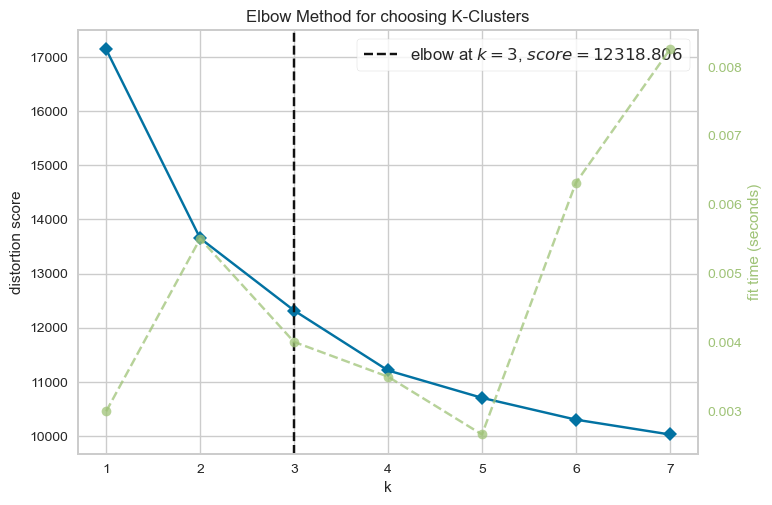

<Axes: title={'center': 'Elbow Method for choosing K-Clusters'}, xlabel='k', ylabel='distortion score'>

In [1167]:
# In order to use K-Means clustering, first I want to use the elbow method to determine the optimal number of clusters

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 8), timings=True)

# Fit the data to the visualizer
visualizer.fit(pca_data)
visualizer.title = 'Elbow Method for choosing K-Clusters'
visualizer.show()

In [1168]:
# Fit KMeans Model using optimal number of clusters

kmeans = KMeans(n_clusters=3, random_state=0).fit(pca_data)

In [1169]:
# Add cluster labels to the data frame and Inverse Transform the data

data['cluster'] = kmeans.labels_
data.shape


(1146, 51)